In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import print_cv_results


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Семинар - Линейные модели для задачи классификации
В качестве демонстрации будем использовальзовать датасет с изображениями цифр 

In [2]:
# Загрузим данные
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
X = digits.data
y = digits.target

In [4]:
# Посмотрим на кол-во объектов 
X.shape, y.shape

((1797, 64), (1797,))

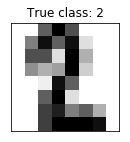

In [5]:
# Давайте, посмотрим, как вылядит случайный объект нашей выборки
target_image_id = np.random.randint(X.shape[0])

plt.figure(figsize=(4,2))
plt.imshow(X[target_image_id].reshape((8, 8)), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.title('True class: '+ str(y[target_image_id]))
plt.show()

In [24]:
# Посмотрим на баланс классов 
class_counts = np.unique(y, return_counts=True)

pd.DataFrame(class_counts[1], index=class_counts[0]
             , columns=['Counts'])

,Counts
0,178
1,182
2,177
3,183
4,181
5,182
6,181
7,179
8,174
9,180


## Логистическая регрессия для многоклассовой классификации

In [7]:
# Загрузим нужные библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [8]:
# Разделим выборку на тренировочную и тестовую 
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                 train_size=0.8, test_size=0.2, shuffle=True,
                 random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

*Логистическая регрессия позволяет решать задачу многоклассовой классификации. Класс ``LogisticRegression`` позвляет это делать двумя способами:* 
- Стандартный One vs Rest (т.е. каждый класс отделяется от всех других). Параметр `multi_class='ovr'`.*
- Используя кросс-энтропию (оценивается сразу вектор вероятностей принадлежности классам). Параметр `multi_class='multinomial'`.*

#### One vs Rest
Find 𝐾 − 1 classifiers 𝑓 , 𝑓 , ... , 𝑓 12 𝐾−1  
- 𝑓 classifies1𝑣𝑠{2,3,...,𝐾} 1
- 𝑓 classifies2𝑣𝑠{1,3,...,𝐾} 2
- ...
- 𝑓 classifies𝐾−1𝑣𝑠{1,2,...,𝐾−2}
- 𝐾−1
- Points not classified to classes {1,2, ... , 𝐾 − 1} are put to class 𝐾

#### Cross-entropy


В случае с бинарной классификацией функция потерь: 
$$ \sum_{i=1}^l \bigl( y_i \log a_i - (1-y_i) \log (1-a_i) \bigr)  \rightarrow min$$  
$a_i$ – ответ (вероятность) алгоритма на i-м объекте на вопрос принадлежности к классу $y_i$

Обобщается для многомерного случая:
$$-\frac{1}{q} \sum_{i=1}^q \sum_{j=1}^l y_{ij} \log a_{ij} \rightarrow min $$
где  
$q$ – число элементов в выборке,  
$l$ – число классов,   
$a_{ij}$ – ответ (вероятность) алгоритма на i-м объекте на вопрос принадлежности его к j-му классу

__Проблемы:__ 

- Сложности в поиске глобального минимума, так как присутствуют Локальные минимумы и плато

In [9]:
%%time
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
lr.fit(x_train,y_train)

CPU times: user 466 ms, sys: 66.7 ms, total: 533 ms
Wall time: 831 ms


In [10]:
accuracy_score(lr.predict(x_test), y_test)

0.9611111111111111

# liblinear 
Используется обычный покоординантный спуск. 
Алгоритм:
- Инициализацируем любыми значениями вектор весов
    - Повторяем для каждого i из пространства признаков:
        - фиксируем значения всех переменных кроме $x_i$
        - проводим одномерную оптимизацию по переменной $x_i$, любым методом одномерной оптимизации
        - если достигнули минимума по одной координате, то возвращаем текущее значение вектора весов

Как это выглядит? 
<img src="../pic/Coordinate_descent.png" alt="Drawing" style="width: 400px;"/>

__Недостатки:__
- Не параллелится 
- Может "застрять" в локальном минимуме
- Следствие п.2 - Не может использоваться кросс-энтропия для многомерного случая, так как легко "Застревает" в локальных минимумах. Вместо этого для каждого класса строит отдельный классификатор (One-vs-Rest) 

In [11]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c), 
    'penalty': ['l1', 'l2']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy') 
gs.fit(x_train, y_train)

CPU times: user 337 ms, sys: 44.6 ms, total: 382 ms
Wall time: 5.86 s


In [12]:
accuracy_score(gs.predict(x_test), y_test)

0.9638888888888889

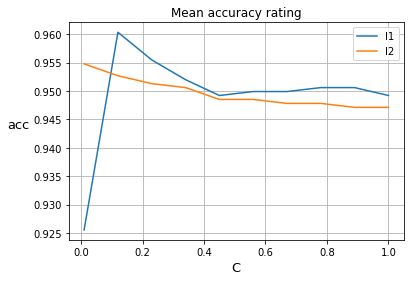

In [13]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','penalty')

<img src="../pic/solvers_ovr.png" alt="Drawing" style="width: 600px;"/>
  
Source: [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

### Почему L1 штраф не применяется для градиентных методов? 

По сути, мы добавляем сумму модулей весов к функции потерь, но как Вы знаете, производная функции модуля при x = 0 не определена, поэтому, возникают сложности с градиентными методами. 



### Stochatic Average Gradient (SAG)
Объединение градиентного спуска и стохастического. 
При этом, он имеет низкую стоимость итерации свойственной SGD, но делает шаг градиента по отношению к аппроксимации полного градиента:
<img src="../pic/sag.png" alt="Drawing" style="width: 500px;"/>



__Недостатки:__
- Нет L1
- Непрактичен для больших выборок, так как имеет высокую вычислительную сложность

# Stochatic Average Gradient Augmented (SAGA)

SAGA является вариантом SAG, но который поддерживает опцию non-smooth penalty=l1 (т. е. регуляризацию L1).

[Подробнее: ](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf)

In [14]:
lr_clf = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=500)

In [15]:
%%time
gs=GridSearchCV(lr_clf,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy') 
gs.fit(x_train/16, y_train)

CPU times: user 1.46 s, sys: 68 ms, total: 1.53 s
Wall time: 31.3 s


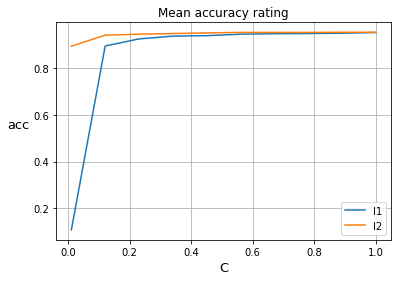

In [16]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','penalty')

In [23]:
accuracy_score(gs.predict(x_test), y_test)

0.07777777777777778

## Метод опорных векторов для многоклассовой классификации

In [18]:
from sklearn.svm import SVC

In [26]:
svc = SVC(kernel='linear')
svc.fit(x_train/16, y_train)
accuracy_score(svc.predict(x_test), y_test)

0.8666666666666667

#### Выбор ядра

Оценим качество модели с применением разных ядер

In [20]:
len_c = 20
param_grid={
    'C': np.linspace(0.001, 10, len_c), 
    'kernel': ['linear', 'rbf', 'poly']
    }

gs=GridSearchCV(svc,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy') 
gs.fit(x_train/16, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 5.27263e-01, 1.05353e+00, 1.57979e+00, 2.10605e+00,
       2.63232e+00, 3.15858e+00, 3.68484e+00, 4.21111e+00, 4.73737e+00,
       5.26363e+00, 5.78989e+00, 6.31616e+00, 6.84242e+00, 7.36868e+00,
       7.89495e+00, 8.42121e+00, 8.94747e+00, 9.47374e+00, 1.00000e+01]), 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

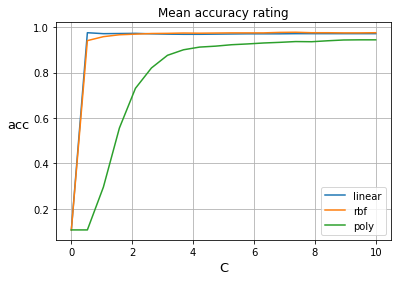

In [27]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','kernel')

##  Метод главных компонент

In [28]:
from sklearn.decomposition import PCA

In [37]:
lr = LogisticRegression()

Посмотрим, как изменяется качество логистической регресии при изменнии колличества компонент

In [39]:
acc_list = []
for index, ax in enumerate(axes.flat):
    n_components = index + 1
    pca = PCA(n_components = n_components).fit(x_train)
    x_pca = pca.transform(x_train)
    lr.fit(x_pca, y_train)
    acc = accuracy_score(lr.predict(pca.transform(x_test)), y_test)
    acc_list = np.append(acc_list, acc)

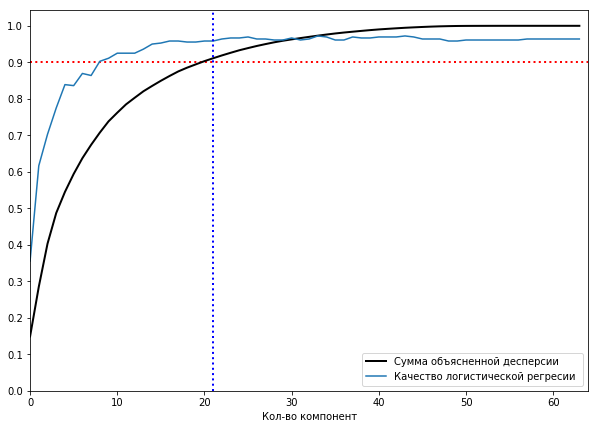

In [40]:
pca = PCA().fit(X)

plt.figure(figsize=(10,7))

plt.plot(np.cumsum(pca.explained_variance_ratio_), 
         color='black', lw=2, label='Сумма объясненной десперсии')
plt.plot(acc_list, label='Качество логистической регресии ')

plt.hlines(0.9,0,64, color='r', lw=2,  linestyle=':')
plt.axvline(np.min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.90))+1, 
             linestyle=':' , color='b', lw=2)

plt.xlim(0, X.shape[1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc=4)
plt.xlabel('Кол-во компонент')
plt.show()

#### Изменение размерности для визуализации

In [41]:
pca = PCA(n_components=2)
x_pca_2 = pca.fit_transform(x_train)

In [42]:
fr_com_pca = x_pca_2[:,0]
sec_com_pca = x_pca_2[:,1]

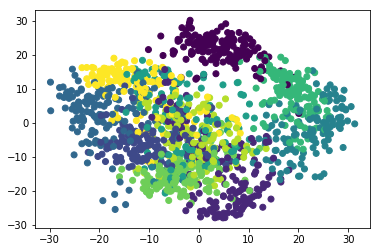

In [49]:
plt.scatter(fr_com_pca, sec_com_pca, c=y_train)
plt.show()

Как видите, PCA не всегла может быть серебрянной пулей, попробуем другой метод, но подробно будем разбирать его позже

In [50]:
from sklearn.manifold import TSNE

In [51]:
t_sne = TSNE()

In [52]:
x_sne_2 = t_sne.fit_transform(x_train)

In [53]:
fr_com_sne = x_sne_2[:,0]
sec_com_sne = x_sne_2[:,1]

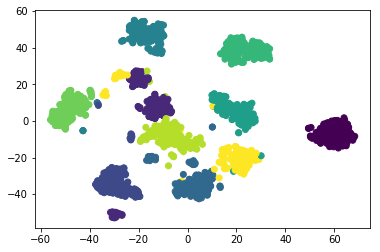

In [54]:
plt.scatter(fr_com_sne, sec_com_sne, c=y_train)
plt.show()

# Что почитать: 
- [Regularized Logistic Regression is Strictly Convex](http://www.qwone.com/~jason/writing/convexLR.pdf)
- [SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives
](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf)
- [Лекции Евгения Соколова](https://github.com/esokolov/ml-course-hse/tree/master/2018-fall/lecture-notes)
- [Препарируем t-SNE](https://habr.com/en/post/267041/)
- [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)